# Analyse des activations des neurones de différents modèles

L'objectif de ce notebook est d'observer si il existe des similarités entre les activations de différents modèles.

Pour cela on dispose d'un jeu de données créer à partir de centaines de modèles avec exactement les mêmes hyperparamètres.
Ces modèles on été entraîné sur le jeux de données MNIST, et ont tous d'excellente performance. Pour chaque modèles on dispose de 10 données d'activations une pour la prédiction de chaque chiffre.

In [23]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

## Configuration

In [3]:
# chemin vers le fichier csv contenant le jeu de données
mm_file = "../../data/activations/multi_mlp.csv"

# Cette variable indique les nombres de neuronnes et le nombre de couche caché 
# elle doit correspondre à celle utilisé pour créer le jeux de données
hidden_sizes = [128, 64] 

In [4]:
activations = pd.read_csv(mm_file)

accuracy = accuracy_score(activations["nb_true"], activations["nb_pred"])
nb_model = int(activations.shape[0] / 10)
print(f"Précision moyenne des {nb_model} modèles : {accuracy:.2f}")

Précision moyenne des 110 modèles : 0.96


## Première analyse

On commence par afficher une image avec les activations de tous les modèles pour prédire un zéro pour voir si l'on observe des paternes évident. On s'attend tout de même à ne rien observer dutout.

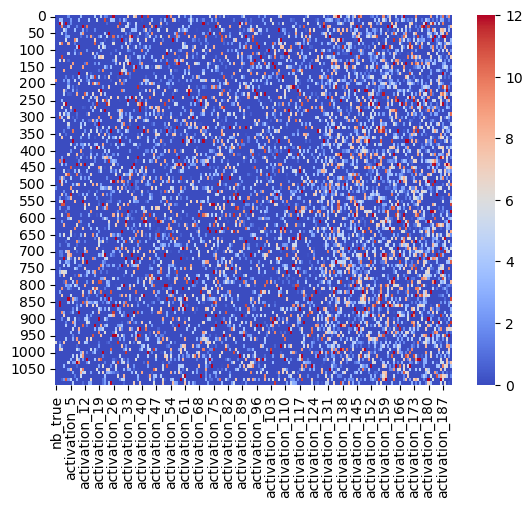

In [5]:
zero_activations = activations[activations["nb_pred"] == 0]
sns.heatmap(zero_activations, cmap="coolwarm", fmt=".2f", vmax=12)
plt.show()

On observe effectivement que entre modèles on ne semble observer aucune similitude évidente.
On va également essayer de faire une analyse en composante principales.

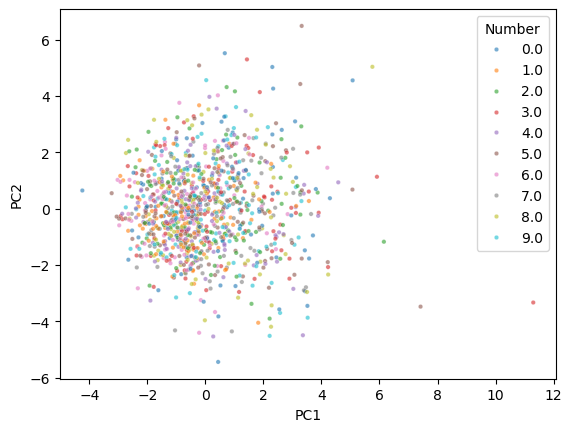

In [6]:
def plot_acp(data, labels):
    # on commence par normaliser les données 
    data_normalized = StandardScaler().fit_transform(data)

    # ensuite on effectue l'ACP avec 2 composantes
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_normalized)

    # transforme les résultats en dataframe 
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['Number'] = labels

    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Number',
        palette='tab10',  # Palette de 10 couleurs
        data=pca_df,
        s=10, alpha=0.6  # Réduire la taille des points pour plus de clarté
    )
    plt.show()

activations_reduced = activations.drop(columns=['nb_true', 'nb_pred'])
plot_acp(activations_reduced, activations["nb_true"])

On observe aussi avec l'ACP que pour différent modèles il ne semble y avoir aucune similitude dans les activations.

## Modèles XGboost

Maintenant on va mettre en place un modèle xgboost qui aura pour objectif de prédire le nombre qui a été prédit en fonction des activations.

Précision du modèle : 0.07


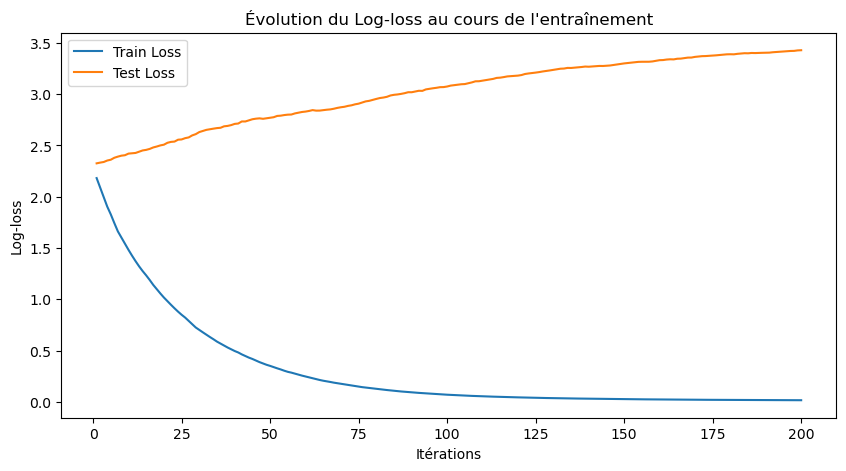

In [38]:
X = activations.iloc[:, 2:]
y = activations["nb_pred"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softmax",  # Problème de classification multiclasses
    "num_class": 10,               # Nombre de classes
    "max_depth": 3,               # Profondeur maximale des arbres
    "eta": 0.3,                   # Taux d'apprentissage (learning rate)
    "eval_metric": "mlogloss"     # Log-loss pour évaluer le modèle
}

num_round = 200
evals = [(dtrain, "train"), (dtest, "eval")]
evals_result = {}

# Entraînement du modèle avec suivi des performances
bst = xgb.train(params, dtrain, num_round, evals=evals, evals_result=evals_result, verbose_eval=False)

# Prédictions
preds = bst.predict(dtest)
accuracy = accuracy_score(y_test, preds)
print(f"Précision du modèle : {accuracy:.2f}")

# 📈 Visualisation de l'évolution du log-loss
epochs = range(1, num_round + 1)
train_loss = evals_result["train"]["mlogloss"]
test_loss = evals_result["eval"]["mlogloss"]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, test_loss, label="Test Loss")
plt.xlabel("Itérations")
plt.ylabel("Log-loss")
plt.title("Évolution du Log-loss au cours de l'entraînement")
plt.legend()
plt.show()

Précision finale du modèle : 0.11


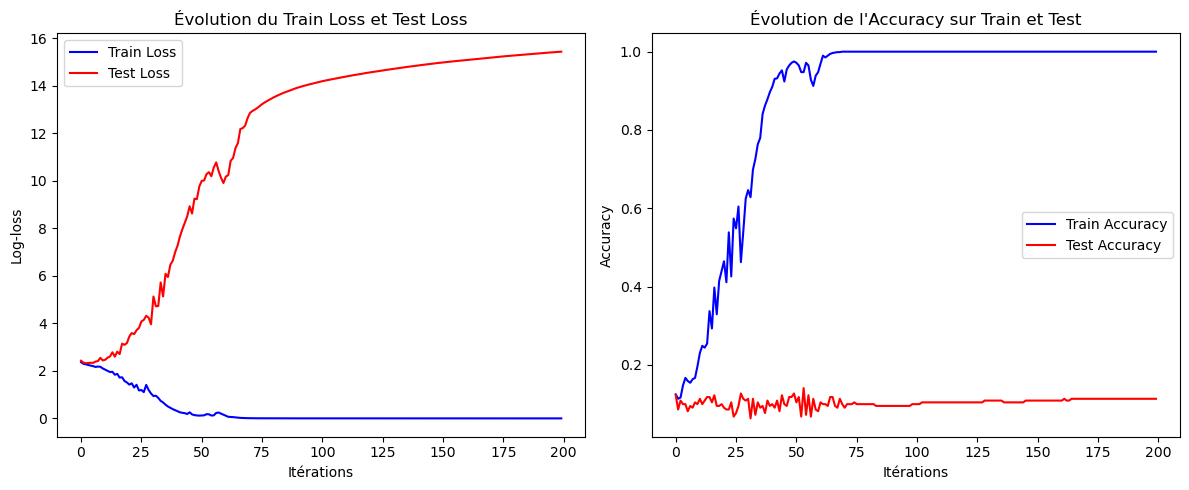

In [36]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64),  # 2 couches cachées (64 et 32 neurones)
                    activation="relu",            # Fonction d'activation ReLU
                    solver="adam",                # Optimiseur Adam
                    learning_rate_init=0.01,      # Taux d'apprentissage
                    max_iter=200,                 # Nombre d'itérations
                    random_state=42)

# Initialisation des variables pour stocker les pertes et accuracies
train_loss = []
test_loss = []
train_acc = []
test_acc = []

# Entraînement manuel avec suivi des pertes et accuracy
for i in range(1, mlp.max_iter + 1):
    mlp.partial_fit(X_train, y_train, classes=np.unique(y))  # Entraînement incrémental
    
    # Prédictions probabilistes
    train_pred_proba = mlp.predict_proba(X_train)
    test_pred_proba = mlp.predict_proba(X_test)
    
    # Calcul du log-loss sur train et test
    train_loss.append(log_loss(y_train, train_pred_proba))
    test_loss.append(log_loss(y_test, test_pred_proba))
    
    # Prédictions finales (classes) pour calculer l'accuracy
    train_pred = mlp.predict(X_train)
    test_pred = mlp.predict(X_test)
    
    train_acc.append(accuracy_score(y_train, train_pred))
    test_acc.append(accuracy_score(y_test, test_pred))

# Précision finale du modèle
print(f"Précision finale du modèle : {test_acc[-1]:.2f}")

# 📈 Visualisation des pertes et accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graphique des pertes (Log-loss)
axes[0].plot(train_loss, label="Train Loss", color='blue')
axes[0].plot(test_loss, label="Test Loss", color='red')
axes[0].set_xlabel("Itérations")
axes[0].set_ylabel("Log-loss")
axes[0].set_title("Évolution du Train Loss et Test Loss")
axes[0].legend()

# Graphique de l'accuracy
axes[1].plot(train_acc, label="Train Accuracy", color='blue')
axes[1].plot(test_acc, label="Test Accuracy", color='red')
axes[1].set_xlabel("Itérations")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Évolution de l'Accuracy sur Train et Test")
axes[1].legend()

plt.tight_layout()
plt.show()